In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

In [3]:
def data_start(label):
    f = uproot.pandas.iterate(f"../outputs/{label}/*.root", "t")
    data = pd.concat([j for j in f])[['label', 'beam_energy', 'mass', 'procedure', 'mass_reco']]
    return data

In [6]:
data11_start = data_start("11")
data19_start = data_start("19")
data12_start = data_start("12")
data17_start = data_start("17")
dataModel_start = data_start("model")

In [7]:
data = dict()
data['11'] = data11_start.set_index(['label'])
data['12'] = data12_start.set_index(['label'])
data['17'] = data17_start.set_index(['label'])
data['19'] = data19_start.set_index(['label'])
data['model'] = dataModel_start.set_index(['label'])

### Вот так выглядит распределение по инвариантной массе

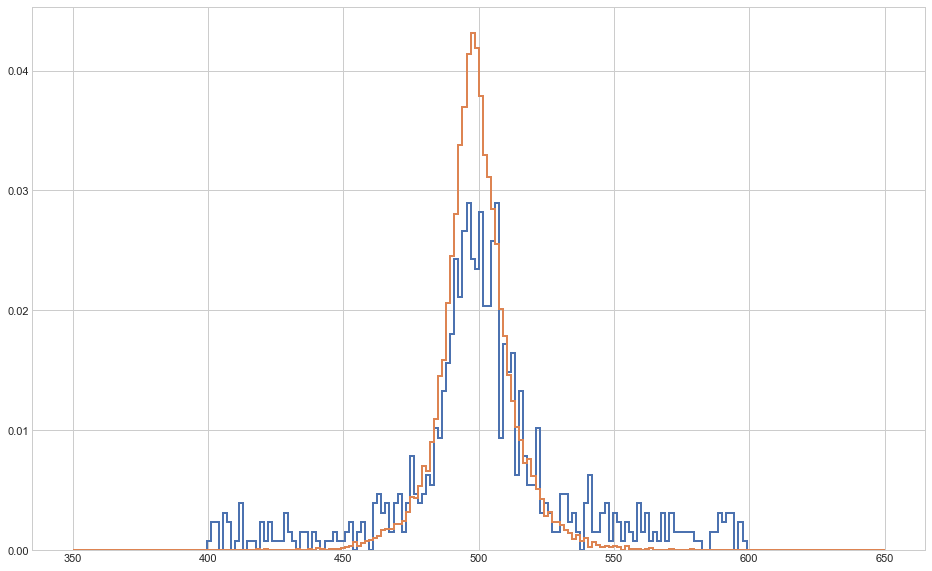

In [13]:
year = '17'
emin, emax = 550, 1100
plt.hist(data=data[year].query('procedure!=2&beam_energy>@emin&beam_energy<=@emax&abs(mass_reco-500)<100'), 
         range=(350, 650), x='mass_reco', bins=200, density=True, label=year, histtype="step", lw=2);
plt.hist(data=data['model'].query('procedure!=2&beam_energy>@emin&beam_energy<=@emax&abs(mass_reco-500)<100'), 
         range=(350, 650), x='mass_reco', bins=200, density=True, label="model", histtype="step", lw=2);

In [9]:
data[year].groupby('label').agg({'procedure':np.size}).tail()

,procedure
label,
950.0,61
971.0,43
981.0,51
990.0,52
1003.5,132


In [10]:
def rec_eff(data):
    rec = pd.pivot_table( data.query('abs(mass_reco-497.6)<5')[['procedure']],  
                         index='label', aggfunc=np.size, columns=['procedure']).fillna(0)
    rec.columns = ['kf', 'st', 'bt']
    rec['kf'] += rec['bt']
    rec['st'] += rec['bt']
    rec['eff'] = (rec['bt']+1.)/(rec['kf']+2)
    rec['err'] = np.sqrt( (rec.bt+1)*(rec.bt+2)/(rec.kf+2)/(rec.kf+3) - np.square((rec.bt+1)/(rec.kf+2)) )
    rec.reset_index(inplace=True)
    return rec

In [26]:
rec= dict()
rec['11'] = rec_eff(data['11'])
rec['12'] = rec_eff(data['12'])
rec['17'] = rec_eff(data['17'])
rec['19'] = rec_eff(data['19'])
rec['model'] = rec_eff(data['model'])

In [13]:
def merging(data, line_from, line_to):
    data['weight'] = data.label*data.kf
    summary = data.loc[line_from:line_to].sum()
    data.loc[line_from:line_to, 'label'] = summary.weight/summary.kf
    data = data.groupby('label').agg({'kf':np.sum, 'st':np.sum, 'bt':np.sum}).reset_index()
    data['eff'] = (data['bt']+1.)/(data['kf']+2)
    data['err'] = np.sqrt( (data.bt+1)*(data.bt+2)/(data.kf+2)/(data.kf+3) - np.square((data.bt+1)/(data.kf+2)) )
    return data

In [40]:
rec[year] = merging(rec[year], 8, 15)

In [41]:
rec[year]

,label,kf,st,bt,eff,err
0,641.000000,56.0,113.0,53.0,0.931034,0.032989
1,650.000000,18.0,23.0,17.0,0.900000,0.065465
2,675.000000,13.0,28.0,12.0,0.866667,0.084984
3,737.500000,24.0,47.0,15.0,0.615385,0.093628
4,800.000000,32.0,50.0,20.0,0.617647,0.082143
5,825.000000,22.0,42.0,17.0,0.750000,0.086603
6,840.000000,12.0,24.0,9.0,0.714286,0.116642
7,901.735001,20.0,27.0,12.0,0.590909,0.102519
8,967.758818,17.0,11.0,4.0,0.263158,0.098465


In [42]:
def model_eff(x):
    rec_eff = np.interp(x, rec['model'].label, rec['model'].eff )
    rec_err = np.interp(x, rec['model'].label, rec['model'].err )
    return ( rec_eff, rec_err )
def add_correction(rec):
    rec['eff_m'] = model_eff(rec.label)[0]
    rec['err_m'] = model_eff(rec.label)[1]
    rec['correction'] = rec.eff/rec.eff_m
    rec['correction_error'] = rec.correction*np.sqrt( (rec.err/rec.eff)**2 + (rec.err_m/rec.eff_m)**2 )
    return rec

In [43]:
rec['19'] = add_correction(rec['19'])
rec['17'] = add_correction(rec['17'])
rec['12'] = add_correction(rec['12'])
rec['11'] = add_correction(rec['11'])

Картинка с эффективностью реконструкции для моделирования и эксперимента

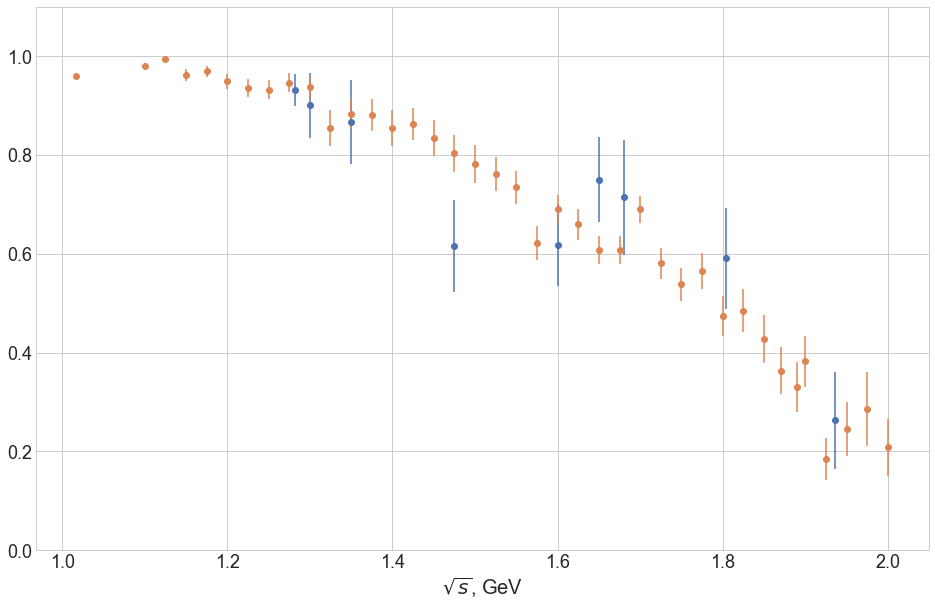

In [44]:
year = '17'
plt.errorbar(x=rec[year]['label']*2e-3, y=rec[year]['eff'], yerr=rec[year]['err'], fmt='o')
plt.errorbar(x=rec['model']['label']*2e-3, y=rec['model']['eff'], yerr=rec['model']['err'], fmt='o')
plt.xlabel("$\sqrt{s}$, GeV", fontsize=20);
ax = plt.gca()
ax.tick_params(labelsize=18)
ax.set_ylim([0.0, 1.1]);

Фитирую поправку константой

In [45]:
year = '17'

In [46]:
import iminuit

In [47]:
def least_squares(c):
    return np.sum((( rec[year].correction - c ) / rec[year].correction_error )**2 )

m = iminuit.Minuit(least_squares, c=1., error_c=0.01, errordef = 1)
m.migrad()

------------------------------------------------------------------
| FCN = 8.57                    |      Ncalls=13 (13 total)      |
| EDM = 7.81E-19 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | c    |   0.981   |   0.030   |            |            |         |         |       |
------------------------------------------------------------------------------------------

Финальная картинка с поправкой

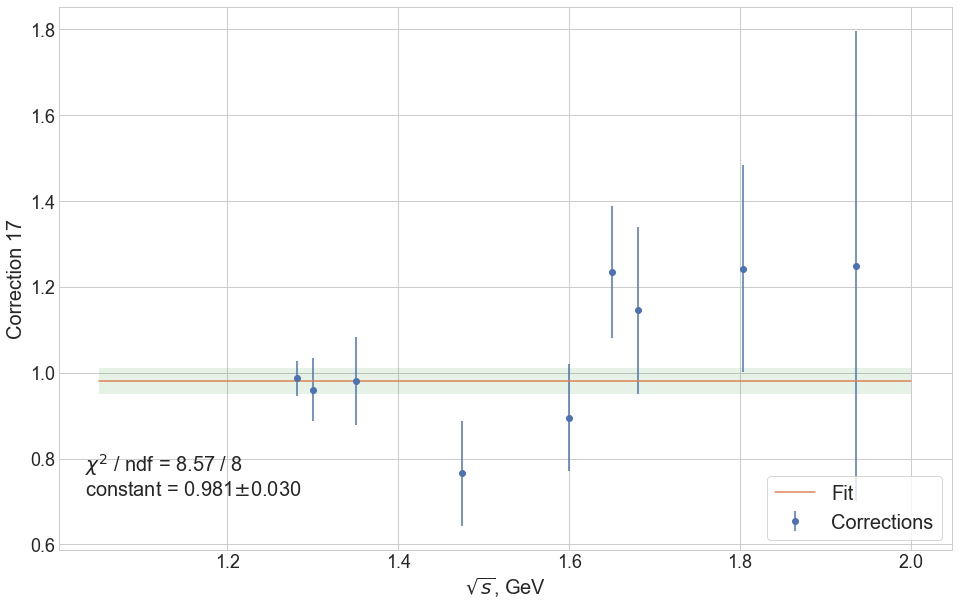

In [49]:
#plot corrections
plt.errorbar(x=rec[year]['label']*2e-3, y=rec[year]['correction'], yerr=rec[year]['correction_error'], 
             fmt='o', label='Corrections')

#plot fitting line
x_line, y_line = np.linspace(1.05, 2., 2), m.np_values()[0]*np.ones(2)
yerr_line = np.ones(2)*m.np_errors()[0]
plt.plot(x_line, y_line, label='Fit')
plt.fill_between(x_line, y_line-yerr_line, y_line+yerr_line, facecolor='green', alpha=0.1, edgecolor='none')

#look friendly
plt.xlabel("$\sqrt{s}$, GeV", fontsize=20);
plt.ylabel(f"Correction {year}", fontsize=20);
ax = plt.gca()
ax.tick_params(labelsize=18)
    #text and legend
text_str = f"$\chi^2$ / ndf = {m.fval:.2f} / {len(rec[year])-1} \nconstant = {m.np_values()[0]:.3f}$\pm${m.np_errors()[0]:.3f}"
ax.text(0.03, 0.1, text_str, transform=ax.transAxes, fontsize=20)
plt.legend(fontsize=20, loc='lower right', frameon=True);

#plt.savefig('correction17.pdf')